# 1. Autoencoder

In [141]:
import warnings
warnings.filterwarnings('ignore')

# importing MNIST dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from keras.datasets import mnist

# importing keras modules
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Embedding
from keras.layers import Conv2D,Conv1D, MaxPooling2D, MaxPooling1D, GlobalMaxPooling1D
from keras import backend as K

# OpenCV package for resizing the MNIST images
from cv2 import *

# other modules
import numpy as np

# diagrams
import matplotlib.pyplot as plt

# pretrained networks
# from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16

# categorical clothes
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

# Pandas for Question 3
import pandas as pd

# TEXT packages
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.MENTION)

In [21]:
# loading MNIST dataset; we don't need labels!
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print(x_test.shape)

(10000, 28, 28, 1)


In [64]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 4, 4, 8)           0  

In [66]:
auto_encoder_trained = autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=150,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 40s 667us/step - loss: 0.1779 - val_loss: 0.1572
Epoch 2/10
60000/60000 [==============================] - 50s 841us/step - loss: 0.1520 - val_loss: 0.1437
Epoch 3/10
60000/60000 [==============================] - 43s 720us/step - loss: 0.1398 - val_loss: 0.1315
Epoch 4/10
60000/60000 [==============================] - 44s 729us/step - loss: 0.1321 - val_loss: 0.1336
Epoch 5/10
60000/60000 [==============================] - 39s 656us/step - loss: 0.1270 - val_loss: 0.1221
Epoch 6/10
60000/60000 [==============================] - 50s 841us/step - loss: 0.1235 - val_loss: 0.1215
Epoch 7/10
60000/60000 [==============================] - 52s 868us/step - loss: 0.1211 - val_loss: 0.1170
Epoch 8/10
60000/60000 [==============================] - 38s 626us/step - loss: 0.1192 - val_loss: 0.1151
Epoch 9/10
60000/60000 [==============================] - 46s 765us/step - loss: 0.1178 - val_

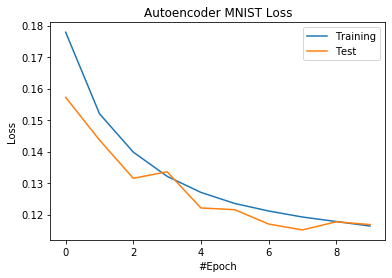

In [71]:
plt.plot(auto_encoder_trained.history['loss'])
plt.plot(auto_encoder_trained.history['val_loss'])
plt.title('Autoencoder MNIST Loss')
plt.ylabel('Loss')
plt.xlabel('#Epoch')
plt.legend(['Training', 'Test'], loc='upper right')
plt.show()

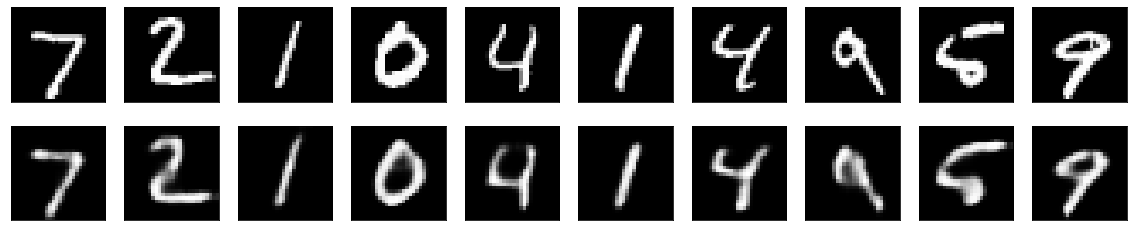

In [79]:
output_img = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    
    # input images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # output images
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(output_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# 2. Image Classification

# 2.1 Deep CNN

In [80]:
model = Sequential()
conv_l1 = Conv2D(filters = 64,kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28,28,1))
model.add(conv_l1)
model.add(MaxPooling2D(pool_size=(2,2)))
conv_l2 = Conv2D(filters = 64,kernel_size=(3, 3), activation='relu', padding='same')
model.add(conv_l2)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_134 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [81]:
cnn_trained = model.fit(x_train,y_train,batch_size=150,epochs=20,validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 42s 700us/step - loss: 0.4088 - accuracy: 0.8726 - val_loss: 0.0681 - val_accuracy: 0.9787
Epoch 2/20
60000/60000 [==============================] - 40s 666us/step - loss: 0.1427 - accuracy: 0.9593 - val_loss: 0.0422 - val_accuracy: 0.9866
Epoch 3/20
60000/60000 [==============================] - 45s 752us/step - loss: 0.1079 - accuracy: 0.9685 - val_loss: 0.0351 - val_accuracy: 0.9881
Epoch 4/20
60000/60000 [==============================] - 44s 728us/step - loss: 0.0871 - accuracy: 0.9740 - val_loss: 0.0302 - val_accuracy: 0.9904
Epoch 5/20
60000/60000 [==============================] - 45s 746us/step - loss: 0.0777 - accuracy: 0.9767 - val_loss: 0.0295 - val_accuracy: 0.9901
Epoch 6/20
60000/60000 [==============================] - 52s 861us/step - loss: 0.0719 - accuracy: 0.9790 - val_loss: 0.0289 - val_accuracy: 0.9905
Epoch 7/20
60000/60000 [==============================] 

# 2.2 Transfer Learning

In [22]:
# Constants
CATS = 10
IMG_W, IMG_H = 48, 48
TRAIN_SIZE = x_train.shape[0]
TEST_SIZE = x_test.shape[0]
HIDDEN_SIZE = 300

y_train = np_utils.to_categorical(y_train, CATS)
y_test = np_utils.to_categorical(y_test, CATS)
x_train_categorical = np.array([cv2.resize(x, (IMG_W,IMG_H)) for x in x_train])
x_test_categorical = np.array([cv2.resize(x, (IMG_W,IMG_H)) for x in x_test])
x_train_categorical = x_train_categorical.reshape(TRAIN_SIZE, 48, 48,1)
x_test_categorical  = x_test_categorical.reshape(TEST_SIZE, 48, 48, 1)

# Make it suitable for ResNet! i.e., repeat third dimension
x_train_categorical = x_train_categorical.repeat(3, axis=-1)
x_test_categorical  = x_test_categorical.repeat(3, axis=-1)

print(x_train_categorical.shape)
print(x_test_categorical.shape)

(60000, 48, 48, 3)
(10000, 48, 48, 3)


In [35]:
# base_model = ResNet50(weights= None, include_top=False, input_shape= (IMG_W,IMG_H,3))
base_model_vgg = VGG16(weights= 'imagenet', include_top=False, input_shape= (IMG_W,IMG_H,3))

model = Sequential()
model.add(base_model_vgg)
model.add(Flatten())
model.add(Dense(HIDDEN_SIZE, activation="relu"))
model.add(Dense(CATS, activation="softmax"))

base_model_vgg.trainable = False
model.summary()
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])



58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                3010      
Total params: 14,871,598
Trainable params: 156,910
Non-trainable params: 14,714,688
_________________________________________________________________


In [37]:
tr2_model = model.fit(x_train_categorical, y_train,
          batch_size=200, epochs=5, 
          validation_data=(x_test_categorical, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 422s 7ms/step - loss: 0.2552 - accuracy: 0.9306 - val_loss: 0.1659 - val_accuracy: 0.9518
Epoch 2/5
60000/60000 [==============================] - 406s 7ms/step - loss: 0.1437 - accuracy: 0.9575 - val_loss: 0.1236 - val_accuracy: 0.9632
Epoch 3/5
60000/60000 [==============================] - 406s 7ms/step - loss: 0.1104 - accuracy: 0.9675 - val_loss: 0.1022 - val_accuracy: 0.9700
Epoch 4/5
60000/60000 [==============================] - 426s 7ms/step - loss: 0.0930 - accuracy: 0.9720 - val_loss: 0.0908 - val_accuracy: 0.9721
Epoch 5/5
60000/60000 [==============================] - 429s 7ms/step - loss: 0.0837 - accuracy: 0.9746 - val_loss: 0.0991 - val_accuracy: 0.9694


In [38]:
eval_score = model.evaluate(x_test_categorical, y_test, batch_size=150, verbose = 0)

print('Train loss: {}, accuracy: {}'.format(tr2_model.history['loss'][4],tr2_model.history['accuracy'][4])) 
print('Test loss: {}, accuracy: {}'.format(eval_score[0],eval_score[1])) 


Train loss: 0.08369632729018728, accuracy: 0.9746333360671997
Test loss: 0.09907448459416628, accuracy: 0.9693999886512756


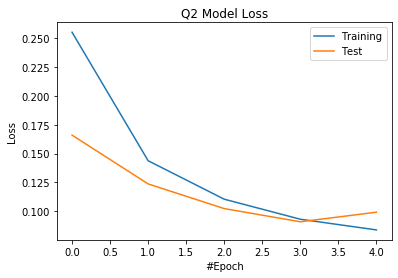

In [40]:
plt.plot(tr2_model.history['loss'])
plt.plot(tr2_model.history['val_loss'])
plt.title('Q2 Model Loss')
plt.ylabel('Loss')
plt.xlabel('#Epoch')
plt.legend(['Training', 'Test'], loc='upper right')
plt.show()

# 3. Text Classification

# 3.1 RNN

In [58]:
tweets = pd.read_csv("tweets_with_labels.csv",sep ="\t")
tweets.head()

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0


In [60]:
def preprocess_tweet(tweet):
    preprocessed = p.clean(tweet.lower())
    return preprocessed

# preprocessing tweets; removing hashtags, urls, emojies, smilies, and etc.
tweets['tweet'] = tweets['tweet'].apply(preprocess_tweet) 

In [146]:

tweets.head()

K = 15

x, y = tweets['tweet'], tweets.drop(['id','tweet'], axis=1).values

# Split 80-10-10
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=1234)
x_val, x_test, y_val, y_test = train_test_split(x_test,y_test, test_size=0.50, random_state=1234)


In [147]:
# print(x_train['tweet'])
MAX_WORDS = 100

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train) 
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(x_test)

# truncate and pad input sequences
MAX_LEN = 500
x_train = pad_sequences(x_train, maxlen=MAX_LEN)
x_val = pad_sequences(x_val, maxlen=MAX_LEN)
x_test = pad_sequences(x_test, maxlen=MAX_LEN)

In [119]:
lstm_model = Sequential()
lstm_model.add(Embedding(MAX_WORDS, 128))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(15, activation ='softmax'))
lstm_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
lstm_trained = lstm_model.fit(x_train, y_train,
                              epochs = 15, batch_size = 200,
                              validation_data =(x_val,y_val),verbose=1)

Train on 62356 samples, validate on 7795 samples
Epoch 1/15
62356/62356 [==============================] - 229s 4ms/step - loss: 2.1091 - accuracy: 0.5530 - val_loss: 1.6352 - val_accuracy: 0.7311
Epoch 2/15
62356/62356 [==============================] - 208s 3ms/step - loss: 1.5881 - accuracy: 0.7441 - val_loss: 1.5572 - val_accuracy: 0.7539
Epoch 3/15
62356/62356 [==============================] - 204s 3ms/step - loss: 1.5777 - accuracy: 0.7478 - val_loss: 1.5754 - val_accuracy: 0.7464
Epoch 4/15
62356/62356 [==============================] - 214s 3ms/step - loss: 1.5964 - accuracy: 0.7490 - val_loss: 1.5847 - val_accuracy: 0.7448
Epoch 5/15
62356/62356 [==============================] - 212s 3ms/step - loss: 1.6012 - accuracy: 0.7461 - val_loss: 1.5843 - val_accuracy: 0.7496
Epoch 6/15
62356/62356 [==============================] - 208s 3ms/step - loss: 1.6107 - accuracy: 0.7459 - val_loss: 1.5900 - val_accuracy: 0.7498
Epoch 7/15
62356/62356 [==============================] - 202s 

In [123]:
eval_score = lstm_model.evaluate(x_test, y_test, batch_size=150, verbose = 0)

In [127]:
print('Train; loss: {}, accuracy: {}'.format(lstm_trained.history['loss'][4],lstm_trained.history['accuracy'][4])) 
print('Test; loss: {}, accuracy: {}'.format(eval_score[0],eval_score[1])) 

Train; loss: 1.601231664413439, accuracy: 0.7460869550704956
Test; loss: 1.7717114181530789, accuracy: 0.740346372127533


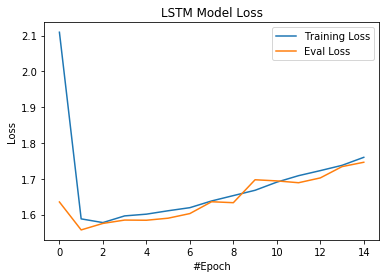

In [126]:
plt.plot(lstm_trained.history['loss'])
plt.plot(lstm_trained.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('#Epoch')
plt.legend(['Training Loss', 'Eval Loss'], loc='upper right')
plt.show()

Seems that the model has already converged. Epoch 1 should be identified as early stopping point (if one wants to do it)

# 3.2 CNN

In [148]:
conv_model = Sequential()

conv_model.add(Embedding(MAX_WORDS,128))

# for text, 1D Convolution
conv_model.add(Conv1D(64 ,3 ,activation='relu', padding='valid'))

conv_model.add( GlobalMaxPooling1D() )

conv_model.add( Dropout(0.2) )

conv_model.add( Dense(64,activation='relu') )

# K is the number of classes i.e. labels
conv_model.add( Dense(K,activation='sigmoid') )
conv_model.summary()
conv_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['acc'])
conv_model_trained = conv_model.fit(x_train, y_train,
                            batch_size = 100, epochs = 15,
                            validation_data =(x_val, y_val),verbose=1)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 128)         12800     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 64)          24640     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_32 (Dense)             (None, 15)                975       
Total params: 42,575
Trainable params: 42,575
Non-trainable params: 0
_________________________________________________

In [149]:
eval_score = conv_model.evaluate(x_test, y_test, batch_size=150, verbose = 0)

In [157]:
print('Train; loss: {}, accuracy: {}'.format(conv_model_trained.history['loss'][14],conv_model_trained.history['acc'][14])) 
print('Test; loss: {}, accuracy: {}'.format(eval_score[0],eval_score[1])) 

Train; loss: 1.365059420520908, accuracy: 0.7661492228507996
Test; loss: 1.3967421489927232, accuracy: 0.7642078399658203


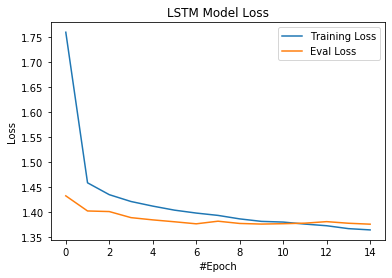

In [158]:
plt.plot(conv_model_trained.history['loss'])
plt.plot(conv_model_trained.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('#Epoch')
plt.legend(['Training Loss', 'Eval Loss'], loc='upper right')
plt.show()

In [ ]:
# 3.3 